In [1]:
import pandas as pd
import numpy as np

file = "Canberra_Merged_Weather_Transport.csv"
df = pd.read_csv(file)

df['Date'] = pd.to_datetime(df['Date'])

df['Weather_Code'] = df['Weather_Code'].astype('category')

df['School'] = df['School'].fillna(0)
df['Other'] = df['Other'].fillna(0)

df['Total_Passengers'] = (
    df['Local Route'] + df['Light Rail'] + df['Peak Service'] +
    df['Rapid Route'] + df['School'].fillna(0) + df['Other'].fillna(0)
)

df['Weekday'] = df['Date'].dt.dayofweek
df['Is_Weekend'] = df['Weekday'].isin([5, 6])

In [2]:
df = df.sort_values('Date')

df.fillna(method='ffill', inplace=True)

features = [
    'Max_Temp_C', 'Min_Temp_C', 'Mean_Temp_C',
    'Precipitation_mm', 'Rain_mm', 'Precip_Hours',
    'Daylight_sec', 'Sunshine_sec', 'Max_Wind_Speed_mps',
    'Weekday'
]

target = 'Total_Passengers'

data = df[features + [target]].values

C:\Users\11849\AppData\Local\Temp\ipykernel_23740\3710535044.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [3]:
n_steps = 7
X_seq, y_seq = [], []

for i in range(len(data) - n_steps):
    X_seq.append(data[i:i + n_steps])
    y_seq.append(data[i + n_steps, -1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [4]:
from sklearn.model_selection import train_test_split

split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

In [5]:
from sklearn.preprocessing import StandardScaler

n_samples, time_steps, n_features = X_train.shape

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(n_samples, time_steps, n_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps, X_seq.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\11849\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,569 (84.25 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9120 - val_loss: 0.6702
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5241 - val_loss: 0.3456
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2855 - val_loss: 0.2425
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1783 - val_loss: 0.1715
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1300 - val_loss: 0.1555
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1457 - val_loss: 0.1447
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1024 - val_loss: 0.1496
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0865 - val_loss: 0.1656
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1150 - val_loss: 0.1388
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0976 - val_loss: 0.1348
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0942 - val_loss: 0.1314
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0743 - val_lo

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 7587.25
R² Score: 0.8143


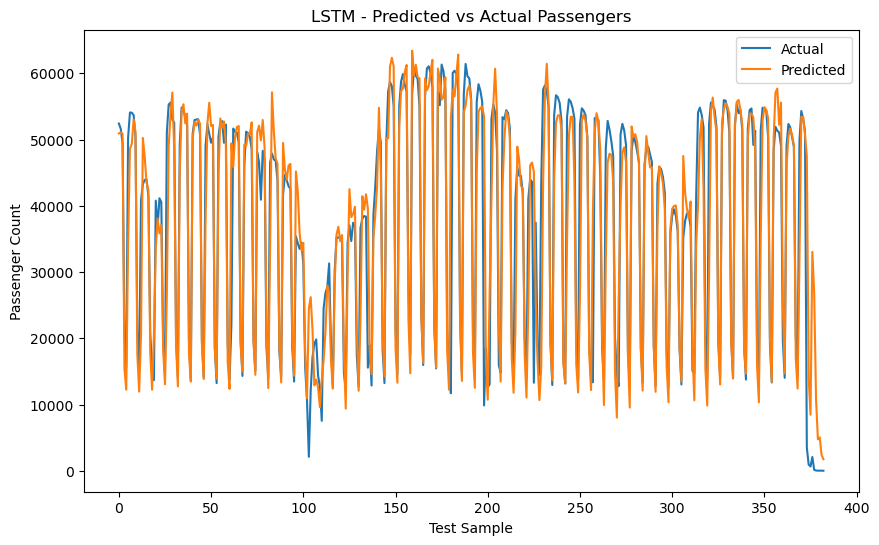

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("LSTM - Predicted vs Actual Passengers")
plt.xlabel("Test Sample")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()
